In [2]:
import matplotlib.pyplot as plt
import csv
import pandas as pd
import scipy.stats as sts
import math
import os
import glob
import warnings

In [34]:
def plot_all(dfs, key='Perf', name=''):
    n_runs = len(dfs)
    lines = []
    for df in dfs:
        value = df[key]
        line, = plt.plot(range(len(value)), value, label=name)
        lines.append(line)
    plt.xlabel('Iterations')
    plt.ylabel(key)
    return lines

def moments(dfs):
    cdf = pd.concat(dfs, sort=True).groupby(level=0)
    return cdf.mean(), cdf.std().fillna(0)
    
def plot_ci(dfs, key='Perf', conf=0.95, name='', step=1):
    n_runs = len(dfs)
    mean_df, std_df = moments(dfs)
    mean = mean_df[key]
    x = list(range(len(mean)))
    mean = mean[1:-1:step]
    std = std_df[key][1:-1:step]
    
    line, = plt.plot(x[1:-1:step], mean, label=name)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="invalid value encountered in multiply")
        interval = sts.t.interval(conf, n_runs-1,loc=mean,scale=std/math.sqrt(n_runs))
    plt.fill_between(x[1:-1:step], interval[0], interval[1], alpha=0.3)
    return line

def load_all(name):
    return [pd.read_csv(file, index_col=False) for file in glob.glob("*.csv") if file.startswith(name + '_')]

def compare(env, names, keys=['Perf'], conf=0.95, logdir=None, separate=False, ymin=None, ymax=None, step=1):
    for key in keys:
        plt.figure()
        if ymin is not None and ymax is not None:
            plt.ylim(ymin, ymax)
        if logdir is not None:
            os.chdir(logdir)
        handles = []
        for name in names:
            dfs = load_all(env + '_' + name)
            if separate:
                handles+=(plot_all(dfs, key, name))
            else:
                handles.append(plot_ci(dfs, key, conf, name, step))
        plt.legend(handles=handles)
        plt.show()

# LQG SAFE

In [15]:
os.chdir('/home/matteo/policy-optimization/results/lqg_safe')
dfs = load_all('lqgd')

### SEPG vs Pirotta 2013

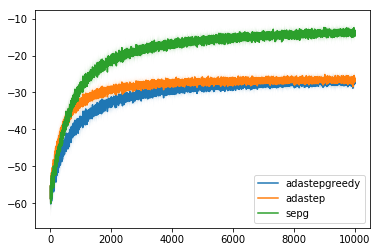

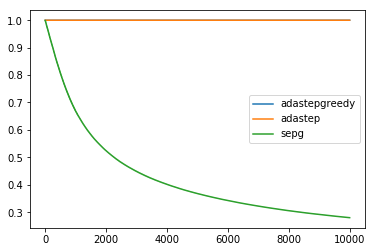

In [44]:
compare('lqgd', 
        ['adastepgreedy', 'adastep', 'sepg'], 
        ['Perf','Exploration'],
        separate=False, conf=0.95)

### SEPG MI vs BUDGET-SEPG

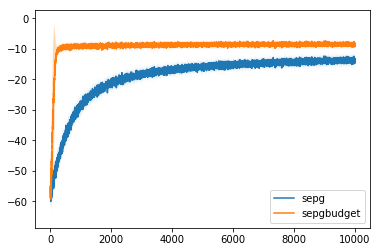

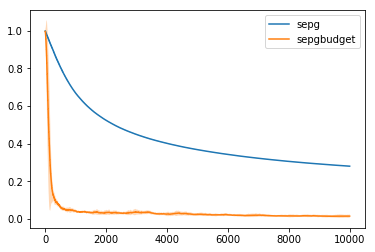

In [43]:
compare('lqgd', 
        ['sepg', 'sepgbudget'], 
        ['Perf','Exploration'],
        separate=False, conf=0.95)

### All together

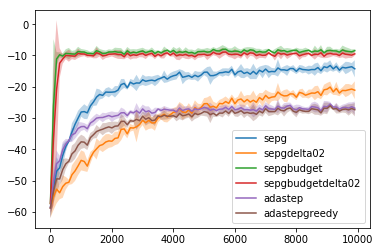

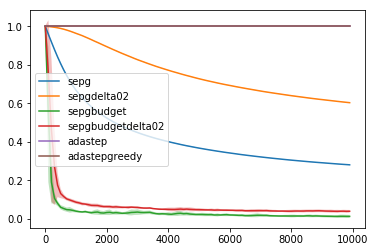

In [45]:
compare('lqgd', 
        ['sepg', 'sepgdelta02', 'sepgbudget', 'sepgbudgetdelta02', 'adastep', 'adastepgreedy'], 
        ['Perf','Exploration'],
        separate=False, conf=0.95, step=100)